# WINGS Advanced Targets and Custom Ansatze

This notebook tests various target wavefunctions and custom ansatz configurations.

**Tests covered:**
- Gaussian with different widths (σ) and shifts (x₀)
- Lorentzian wavefunctions
- Hyperbolic secant (sech) wavefunctions
- Custom user-defined wavefunctions
- Custom hardware-efficient ansatze
- Entanglement pattern comparison

In [1]:
# ============================================================================
# FRESH START - Run this FIRST after kernel restart
# ============================================================================
import sys
from pathlib import Path

# Clean up sys.path - remove any gaussian_state_optimizer paths
sys.path = [p for p in sys.path if 'gaussian_state_optimizer' not in p and 'optimization' not in p]

# Add the correct path
src_path = Path.cwd() / 'optimization-files' / 'src'
sys.path.insert(0, str(src_path))

print("sys.path (first 3):")
for p in sys.path[:3]:
    print(f"  {p}")

# Now verify the package exists at that location
init_file = src_path / 'gaussian_state_optimizer' / '__init__.py'
print(f"\n__init__.py exists: {init_file.exists()}")

if init_file.exists():
    print(f"✓ Package found at: {src_path / 'gaussian_state_optimizer'}")
else:
    print(f"✗ Package NOT found. Check your directory structure.")
    print(f"  Looking for: {init_file}")

sys.path (first 3):
  /home/jmc03846/WINGS_debug/optimization-files/src
  /home/jmc03846/WINGS_debug
  

__init__.py exists: True
✓ Package found at: /home/jmc03846/WINGS_debug/optimization-files/src/gaussian_state_optimizer


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

from gaussian_state_optimizer import (
    GaussianOptimizer,
    OptimizerConfig,
    TargetFunction,
    get_backend_info,
)
from gaussian_state_optimizer.config import OptimizationPipeline
from gaussian_state_optimizer.ansatz import (
    DefaultAnsatz,
    CustomHardwareEfficientAnsatz,
)

backend_info = get_backend_info()
USE_CUSTATEVEC = backend_info['custatevec']

print(f"Using cuStateVec: {USE_CUSTATEVEC}")

Detected HPC scratch directory: /scratch/jmc03846
Created/verified directory: /home/jmc03846/lib
Created/verified directory: /scratch/jmc03846/coefficient_cache
Created/verified directory: /scratch/jmc03846/simulation_output
Created/verified directory: /scratch/jmc03846/simulation_data
Created/verified directory: /scratch/jmc03846/optimization_checkpoints
Created/verified directory: /scratch/jmc03846/optimization_campaigns
Using cuStateVec: True


In [3]:
# Common settings
N_QUBITS = 8
MAX_TIME = 60  # seconds per optimization
TARGET_FIDELITY = 0.999

def get_statevector_for_plotting(opt, params):
    """
    Get statevector in correct ordering for plotting.
    
    When using cuStateVec, the internal statevector ordering differs from Qiskit.
    This function handles the conversion automatically.
    """
    if opt.config.use_custatevec and hasattr(opt, '_custatevec_evaluator') and opt._custatevec_evaluator is not None:
        return opt._custatevec_evaluator.get_statevector_qiskit_order(params)
    else:
        return opt.get_statevector(params)

def run_optimization(config, max_time=MAX_TIME, target_fidelity=TARGET_FIDELITY):
    """Run optimization with standard pipeline."""
    opt = GaussianOptimizer(config)
    
    pipeline = OptimizationPipeline(
        target_fidelity=target_fidelity,
        max_total_time=max_time,
        use_adam_stage=True,
        adam_max_steps=500,
        verbose=False,
    )
    
    start = time.time()
    results = opt.run_optimization(pipeline)
    results['total_time'] = time.time() - start
    
    return opt, results

## 1. Gaussian Wavefunction Variations

Testing Gaussian with different widths (σ)

σ = 0.3

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4

Adam Optimization (lr=0.01, max_steps=500)
--------------------------------------------------
  Step     0: F=0.0130876860, |∇|=5.10e-02, lr=0.0100
  Step   100: F=0.8041205051, |∇|=1.99e-01, lr=0.0051
  Time limit reached at step 117

Adam complete: F=0.887040135874 in 601.8s (118 steps)
  Fidelity: 0.8870401359
  Time: 602.0s

σ = 0.5

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4

Adam Optimization (lr=0.01, max_steps=500)
--------------------------------------------------
  Step     0: F=0.0077872447, |∇|=4.81e-02, lr=0.0100
  Step   100: F=0.7957701279, |∇|=1.88e-01, lr=0.0051
  Step   200: F=0.9067896012, |∇|=1.24e-01, lr=0.0100
  Time limit reached at step 229

Adam complete: F=0.961978511433 in 601.3s (230 steps)
  Fidelity: 0.9619785114
  Time: 60

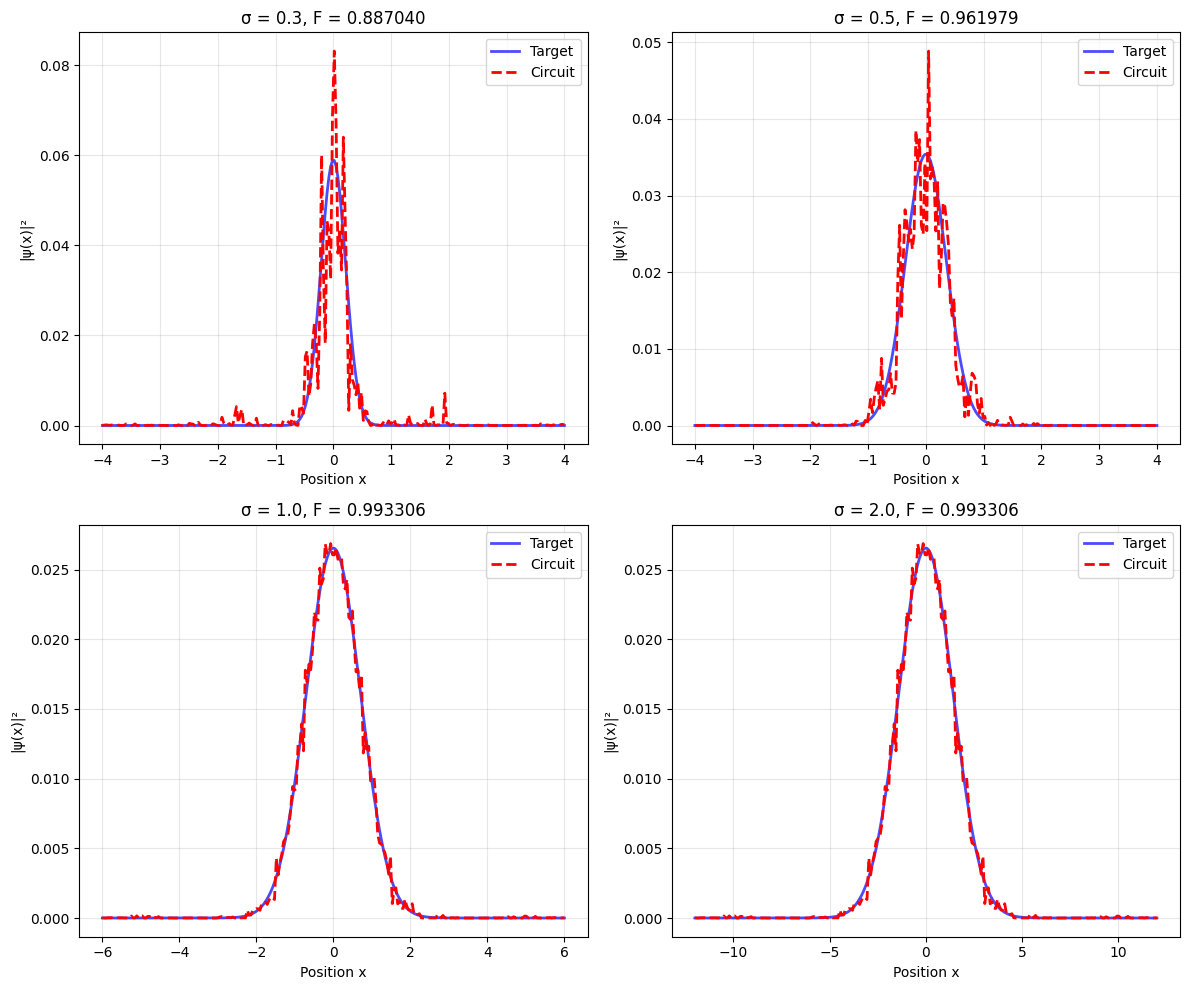

In [4]:
# Test different Gaussian widths
sigma_values = [0.3, 0.5, 1.0, 2.0]
gaussian_results = {}

print("Testing Gaussian with different widths (σ)")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, sigma in enumerate(sigma_values):
    print(f"\nσ = {sigma}")
    
    # Adjust box size based on sigma
    box_size = max(4.0, 6 * sigma)
    
    config = OptimizerConfig(
        n_qubits=N_QUBITS,
        sigma=sigma,
        box_size=box_size,
        target_function=TargetFunction.GAUSSIAN,
        verbose=False,
        use_custatevec=USE_CUSTATEVEC,
        use_gpu=False,
    )
    
    opt, results = run_optimization(config)
    gaussian_results[sigma] = results
    
    print(f"  Fidelity: {results['fidelity']:.10f}")
    print(f"  Time: {results['total_time']:.1f}s")
    
    # Plot
    ax = axes[i]
    x = opt.positions
    optimal_sv = get_statevector_for_plotting(opt, results['optimal_params'])
    
    ax.plot(x, np.abs(opt.target)**2, 'b-', linewidth=2, label='Target', alpha=0.7)
    ax.plot(x, np.abs(optimal_sv)**2, 'r--', linewidth=2, label='Circuit')
    ax.set_xlabel('Position x')
    ax.set_ylabel('|ψ(x)|²')
    ax.set_title(f'σ = {sigma}, F = {results["fidelity"]:.6f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gaussian_widths.png', dpi=150)
plt.show()


Testing Gaussian with different shifts (x₀)

x₀ = -2.0

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4

Adam Optimization (lr=0.01, max_steps=500)
--------------------------------------------------
  Step     0: F=0.0297642909, |∇|=1.35e-01, lr=0.0100
  Step   100: F=0.6442717981, |∇|=9.03e-02, lr=0.0051
  Step   200: F=0.7297888283, |∇|=1.06e-01, lr=0.0100
  Time limit reached at step 231

Adam complete: F=0.906696947695 in 602.6s (232 steps)
  Fidelity: 0.90669695
  Circuit mean: -1.8577303675839556

x₀ = -1.0

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4

Adam Optimization (lr=0.01, max_steps=500)
--------------------------------------------------
  Step     0: F=0.0120136965, |∇|=6.77e-02, lr=0.0100
  Step   100: F=0.8733722062, |∇|=1.24e-01, lr=0.0051
  Step   200: F=0.9262134739, |∇|=6.96e-02, lr=0.0100
  Time limit reached at step 230

Adam compl

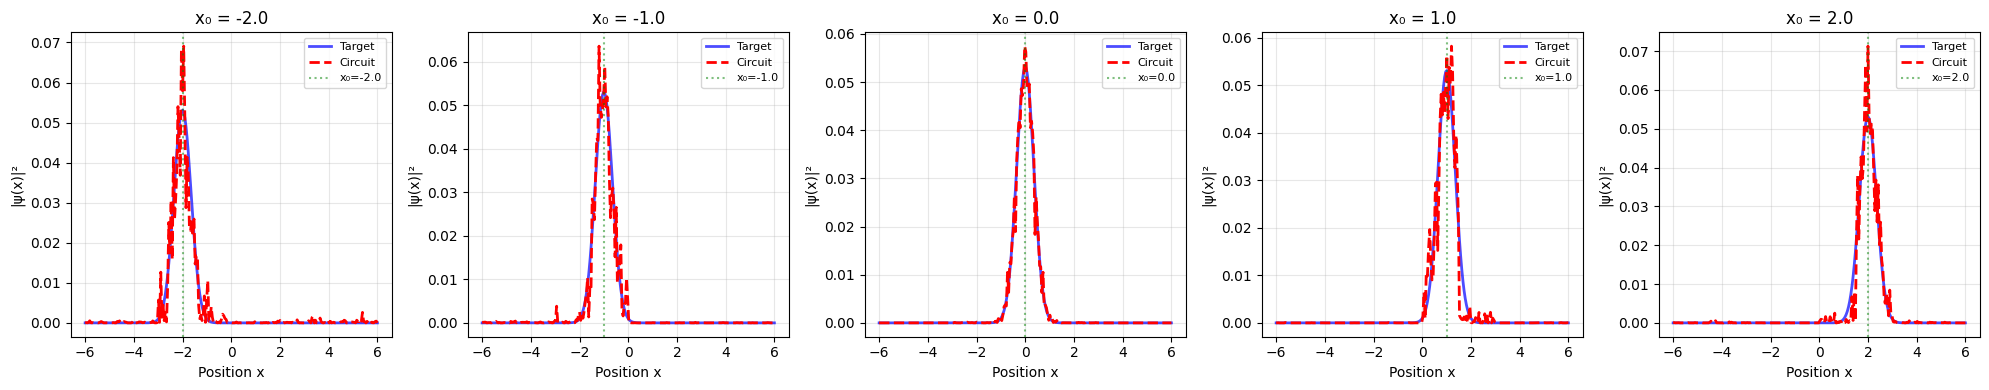

In [5]:
# Test shifted Gaussians
x0_values = [-2.0, -1.0, 0.0, 1.0, 2.0]
shifted_results = {}

print("\nTesting Gaussian with different shifts (x₀)")
print("="*60)

fig, axes = plt.subplots(1, len(x0_values), figsize=(4*len(x0_values), 4))

for i, x0 in enumerate(x0_values):
    print(f"\nx₀ = {x0}")
    
    config = OptimizerConfig(
        n_qubits=N_QUBITS,
        sigma=0.5,
        x0=x0,
        box_size=6.0,  # Larger box to accommodate shifts
        target_function=TargetFunction.GAUSSIAN,
        verbose=False,
        use_custatevec=USE_CUSTATEVEC,
        use_gpu=False,
    )
    
    opt, results = run_optimization(config)
    shifted_results[x0] = results
    
    print(f"  Fidelity: {results['fidelity']:.8f}")
    print(f"  Circuit mean: {results.get('circuit_mean', 'N/A')}")
    
    # Plot
    ax = axes[i]
    x = opt.positions
    optimal_sv = get_statevector_for_plotting(opt, results['optimal_params'])
    
    ax.plot(x, np.abs(opt.target)**2, 'b-', linewidth=2, label='Target', alpha=0.7)
    ax.plot(x, np.abs(optimal_sv)**2, 'r--', linewidth=2, label='Circuit')
    ax.axvline(x=x0, color='g', linestyle=':', alpha=0.5, label=f'x₀={x0}')
    ax.set_xlabel('Position x')
    ax.set_ylabel('|ψ(x)|²')
    ax.set_title(f'x₀ = {x0}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gaussian_shifts.png', dpi=150)
plt.show()

## 2. Lorentzian Wavefunction

Testing Lorentzian wavefunction

γ = 0.2

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4

Adam Optimization (lr=0.01, max_steps=500)
--------------------------------------------------
  Step     0: F=0.0343235140, |∇|=8.63e-02, lr=0.0100
  Step   100: F=0.6472055640, |∇|=8.18e-02, lr=0.0051
  Step   200: F=0.7340665784, |∇|=1.08e-01, lr=0.0100
  Time limit reached at step 231

Adam complete: F=0.913019794054 in 602.5s (232 steps)
  Fidelity: 0.9130197941
  Time: 602.6s

γ = 0.5

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4

Adam Optimization (lr=0.01, max_steps=500)
--------------------------------------------------
  Step     0: F=0.0172217850, |∇|=6.32e-02, lr=0.0100
  Step   100: F=0.7862949454, |∇|=2.21e-01, lr=0.0051
  Step   200: F=0.9521672045, |∇|=1.08e-01, lr=0.0100
  Time limit reached at step 231

Adam complete: F=0.986948985221 in 602.5s (232

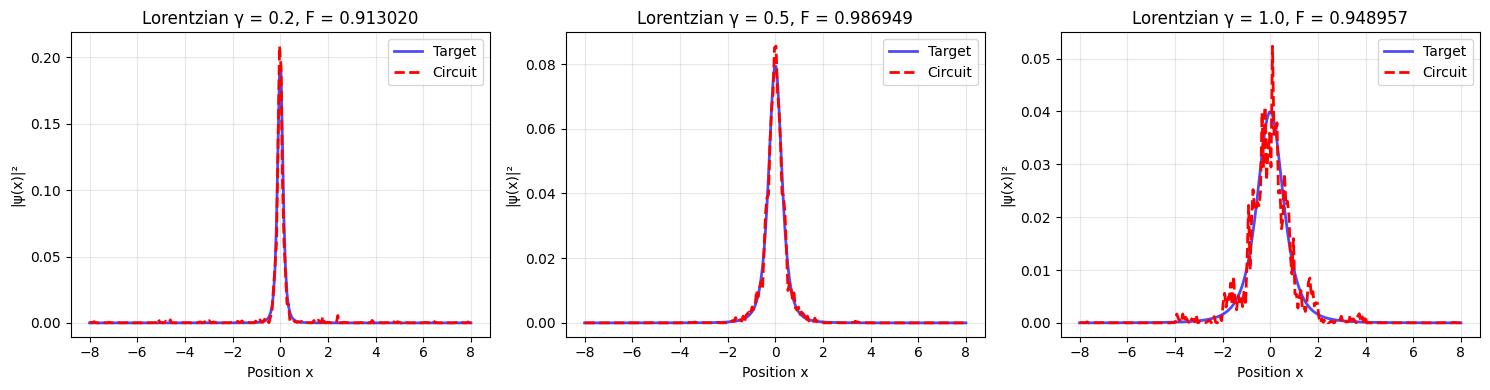

In [6]:
# Test Lorentzian with different gamma values
gamma_values = [0.2, 0.5, 1.0]
lorentzian_results = {}

print("Testing Lorentzian wavefunction")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, gamma in enumerate(gamma_values):
    print(f"\nγ = {gamma}")
    
    config = OptimizerConfig(
        n_qubits=N_QUBITS,
        sigma=0.5,  # Not used for Lorentzian
        target_function=TargetFunction.LORENTZIAN,
        gamma=gamma,
        box_size=8.0,  # Larger box for heavy tails
        verbose=False,
        use_custatevec=USE_CUSTATEVEC,
        use_gpu=False,
    )
    
    opt, results = run_optimization(config)
    lorentzian_results[gamma] = results
    
    print(f"  Fidelity: {results['fidelity']:.10f}")
    print(f"  Time: {results['total_time']:.1f}s")
    
    # Plot
    ax = axes[i]
    x = opt.positions
    optimal_sv = get_statevector_for_plotting(opt, results['optimal_params'])
    
    ax.plot(x, np.abs(opt.target)**2, 'b-', linewidth=2, label='Target', alpha=0.7)
    ax.plot(x, np.abs(optimal_sv)**2, 'r--', linewidth=2, label='Circuit')
    ax.set_xlabel('Position x')
    ax.set_ylabel('|ψ(x)|²')
    ax.set_title(f'Lorentzian γ = {gamma}, F = {results["fidelity"]:.6f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lorentzian_targets.png', dpi=150)
plt.show()

## 3. Hyperbolic Secant (Sech) Wavefunction

In [ ]:
# Test Sech wavefunction
print("Testing Hyperbolic Secant (Sech) wavefunction")
print("="*60)

sigma_values_sech = [0.3, 0.5, 1.0]
sech_results = {}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, sigma in enumerate(sigma_values_sech):
    print(f"\nσ = {sigma}")
    
    config = OptimizerConfig(
        n_qubits=N_QUBITS,
        sigma=sigma,
        target_function=TargetFunction.SECH,
        box_size=max(4.0, 6*sigma),
        verbose=False,
        use_custatevec=USE_CUSTATEVEC,
        use_gpu=False,
    )
    
    opt, results = run_optimization(config)
    sech_results[sigma] = results
    
    print(f"  Fidelity: {results['fidelity']:.10f}")
    print(f"  Time: {results['total_time']:.1f}s")
    
    # Plot
    ax = axes[i]
    x = opt.positions
    optimal_sv = get_statevector_for_plotting(opt, results['optimal_params'])
    
    ax.plot(x, np.abs(opt.target)**2, 'b-', linewidth=2, label='Target', alpha=0.7)
    ax.plot(x, np.abs(optimal_sv)**2, 'r--', linewidth=2, label='Circuit')
    ax.set_xlabel('Position x')
    ax.set_ylabel('|ψ(x)|²')
    ax.set_title(f'Sech σ = {sigma}, F = {results["fidelity"]:.6f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sech_targets.png', dpi=150)
plt.show()

Testing Hyperbolic Secant (Sech) wavefunction

σ = 0.3

Initializing cuStateVec acceleration...
  ✓ cuStateVec initialized
    Precision: double
    Batch simulators: 4

Adam Optimization (lr=0.01, max_steps=500)
--------------------------------------------------
  Step     0: F=0.0090680971, |∇|=5.23e-02, lr=0.0100


## 4. Custom Target Functions

In [ ]:
# Define custom target functions
def double_gaussian(x):
    """Two Gaussian peaks."""
    return np.exp(-((x - 1.5)**2) / 0.3) + np.exp(-((x + 1.5)**2) / 0.3)

def asymmetric_gaussian(x):
    """Asymmetric Gaussian (different widths on each side)."""
    return np.where(x < 0, 
                    np.exp(-x**2 / 0.5),  # Narrow on left
                    np.exp(-x**2 / 2.0))  # Wide on right

def modulated_gaussian(x):
    """Gaussian with sinusoidal modulation."""
    return np.exp(-x**2 / 2.0) * (1 + 0.3 * np.cos(3 * x))

custom_functions = {
    'Double Gaussian': double_gaussian,
    'Asymmetric Gaussian': asymmetric_gaussian,
    'Modulated Gaussian': modulated_gaussian,
}

In [ ]:
print("Testing custom target functions")
print("="*60)

custom_results = {}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, func) in enumerate(custom_functions.items()):
    print(f"\n{name}")
    
    config = OptimizerConfig(
        n_qubits=N_QUBITS,
        sigma=0.5,  # Not directly used
        target_function=TargetFunction.CUSTOM,
        custom_target_fn=func,
        box_size=6.0,
        verbose=False,
        use_custatevec=USE_CUSTATEVEC,
        use_gpu=False,
    )
    
    opt, results = run_optimization(config, max_time=90)  # More time for complex shapes
    custom_results[name] = results
    
    print(f"  Fidelity: {results['fidelity']:.10f}")
    print(f"  Time: {results['total_time']:.1f}s")
    
    # Plot
    ax = axes[i]
    x = opt.positions
    optimal_sv = get_statevector_for_plotting(opt, results['optimal_params'])
    
    ax.plot(x, np.abs(opt.target)**2, 'b-', linewidth=2, label='Target', alpha=0.7)
    ax.plot(x, np.abs(optimal_sv)**2, 'r--', linewidth=2, label='Circuit')
    ax.set_xlabel('Position x')
    ax.set_ylabel('|ψ(x)|²')
    ax.set_title(f'{name}\nF = {results["fidelity"]:.6f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('custom_targets.png', dpi=150)
plt.show()

## 5. Custom Ansatz: Entanglement Patterns

In [ ]:
# Test different entanglement patterns
entanglement_patterns = ['linear', 'circular', 'full']
ansatz_results = {}

print("Testing entanglement patterns with CustomHardwareEfficientAnsatz")
print("="*60)

for pattern in entanglement_patterns:
    print(f"\nEntanglement: {pattern}")
    
    # Create custom ansatz
    ansatz = CustomHardwareEfficientAnsatz(
        n_qubits=N_QUBITS,
        layers=N_QUBITS,  # Same depth as default
        entanglement=pattern,
        rotation_gates=['ry'],
    )
    
    print(f"  Parameters: {ansatz.n_params}")
    
    config = OptimizerConfig(
        n_qubits=N_QUBITS,
        sigma=0.5,
        ansatz=ansatz,
        verbose=False,
        use_custatevec=USE_CUSTATEVEC,
        use_gpu=False,
    )
    
    opt, results = run_optimization(config)
    ansatz_results[pattern] = results
    
    print(f"  Fidelity: {results['fidelity']:.10f}")
    print(f"  Time: {results['total_time']:.1f}s")

In [ ]:
# Compare entanglement patterns
fig, ax = plt.subplots(figsize=(10, 5))

patterns = list(ansatz_results.keys())
fidelities = [ansatz_results[p]['fidelity'] for p in patterns]
times = [ansatz_results[p]['total_time'] for p in patterns]

x = np.arange(len(patterns))
width = 0.35

ax2 = ax.twinx()

bars1 = ax.bar(x - width/2, fidelities, width, label='Fidelity', color='steelblue')
bars2 = ax2.bar(x + width/2, times, width, label='Time (s)', color='coral')

ax.set_xlabel('Entanglement Pattern', fontsize=12)
ax.set_ylabel('Fidelity', fontsize=12, color='steelblue')
ax2.set_ylabel('Time (s)', fontsize=12, color='coral')
ax.set_xticks(x)
ax.set_xticklabels(patterns)
ax.set_title('Entanglement Pattern Comparison', fontsize=14)

# Add value labels
for bar, fid in zip(bars1, fidelities):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{fid:.4f}', ha='center', va='bottom', fontsize=9)

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('entanglement_comparison.png', dpi=150)
plt.show()

## 6. Custom Ansatz: Rotation Gates

In [ ]:
# Test different rotation gate combinations
rotation_configs = [
    ['ry'],           # Default
    ['rx'],           # X rotations
    ['ry', 'rz'],     # Two rotation types
    ['rx', 'ry', 'rz'],  # All three
]

rotation_results = {}

print("Testing rotation gate configurations")
print("="*60)

for gates in rotation_configs:
    name = '+'.join(gates)
    print(f"\nGates: {name}")
    
    ansatz = CustomHardwareEfficientAnsatz(
        n_qubits=N_QUBITS,
        layers=4,  # Fewer layers since more gates per layer
        entanglement='linear',
        rotation_gates=gates,
    )
    
    print(f"  Parameters: {ansatz.n_params}")
    
    config = OptimizerConfig(
        n_qubits=N_QUBITS,
        sigma=0.5,
        ansatz=ansatz,
        verbose=False,
        use_custatevec=USE_CUSTATEVEC,
        use_gpu=False,
    )
    
    opt, results = run_optimization(config)
    rotation_results[name] = {
        'fidelity': results['fidelity'],
        'time': results['total_time'],
        'n_params': ansatz.n_params,
    }
    
    print(f"  Fidelity: {results['fidelity']:.10f}")
    print(f"  Time: {results['total_time']:.1f}s")

In [ ]:
# Visualize rotation gate comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

names = list(rotation_results.keys())
fidelities = [rotation_results[n]['fidelity'] for n in names]
n_params = [rotation_results[n]['n_params'] for n in names]

# Fidelity vs gates
ax = axes[0]
ax.bar(names, fidelities, color='steelblue')
ax.set_xlabel('Rotation Gates')
ax.set_ylabel('Fidelity')
ax.set_title('Fidelity by Gate Configuration')
ax.tick_params(axis='x', rotation=45)

# Fidelity vs parameter count
ax = axes[1]
ax.scatter(n_params, fidelities, s=100, c='coral')
for i, name in enumerate(names):
    ax.annotate(name, (n_params[i], fidelities[i]), 
                textcoords='offset points', xytext=(5, 5), fontsize=9)
ax.set_xlabel('Number of Parameters')
ax.set_ylabel('Fidelity')
ax.set_title('Fidelity vs Parameter Count')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rotation_gates_comparison.png', dpi=150)
plt.show()

## 7. Summary

In [ ]:
print("\n" + "="*70)
print("ADVANCED TARGETS SUMMARY")
print("="*70)

print("\nGaussian Width Tests:")
for sigma, res in gaussian_results.items():
    print(f"  σ={sigma}: F={res['fidelity']:.8f}")

print("\nGaussian Shift Tests:")
for x0, res in shifted_results.items():
    print(f"  x₀={x0:+.1f}: F={res['fidelity']:.8f}")

print("\nLorentzian Tests:")
for gamma, res in lorentzian_results.items():
    print(f"  γ={gamma}: F={res['fidelity']:.8f}")

print("\nSech Tests:")
for sigma, res in sech_results.items():
    print(f"  σ={sigma}: F={res['fidelity']:.8f}")

print("\nCustom Function Tests:")
for name, res in custom_results.items():
    print(f"  {name}: F={res['fidelity']:.8f}")

print("\nEntanglement Pattern Tests:")
for pattern, res in ansatz_results.items():
    print(f"  {pattern}: F={res['fidelity']:.8f}")

print("\nRotation Gate Tests:")
for name, res in rotation_results.items():
    print(f"  {name}: F={res['fidelity']:.8f} (n_params={res['n_params']})")

print("\n" + "="*70)
print("All advanced tests completed!")
print("="*70)